# still in experiment phase-  not working

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## settings (base is a pretrained net or a custom CNN)

In [31]:
# 'InceptionV3' or 'MobileNetV2' or 'cnn'
# base = 'MobileNetV2'
base = 'cnn'
data_augmentation = True

if base == 'cnn':
    preprocess_function = keras.applications.imagenet_utils.preprocess_input
elif base == 'MobileNetV2':
    preprocess_function = keras.applications.mobilenet_v2.preprocess_input
elif base == 'InceptionV3':
    preprocess_function = keras.applications.inception_v3.preprocess_input

image_size = (128, 128)
input_shape = (image_size[0], image_size[1], 3)
batch_size = 32

## train data preparation
dataset is from : https://www.kaggle.com/koryakinp/fingers

In [12]:
# must be one folder per class inside the directory (is not the case in zip from kaggle) 
train_ds = keras.preprocessing.image_dataset_from_directory(
    "../temp/fingers/train",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    "../temp/fingers/test",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 18000 files belonging to 6 classes.
Using 14400 files for training.
Found 3600 files belonging to 6 classes.
Using 720 files for validation.


## some data

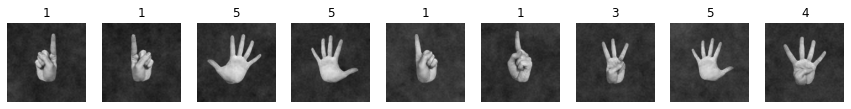

In [13]:
plt.figure(figsize=(15, 2))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(1, 9, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

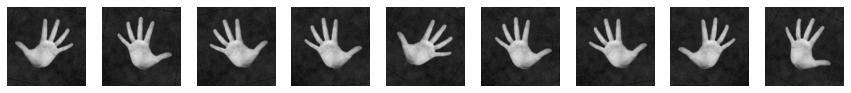

In [33]:
model_data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

# debug - show some
plt.figure(figsize=(15, 2))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = model_data_augmentation(images)
        ax = plt.subplot(1, 9, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## define the model

### A) transfer model 

In [14]:
if base in ['InceptionV3', 'MobileNetV2']:
    if base == 'MobileNetV2':
        base_model_class = keras.applications.MobileNetV2
    else:
        base_model_class = keras.applications.InceptionV3
    
    base_model = base_model_class(
        input_shape=input_shape, 
        include_top=False,  
        weights="imagenet")
    base_model.trainable=False

    model = keras.models.Sequential(name=base)
    model.add(keras.layers.InputLayer(
        input_shape=input_shape))
    model.add(keras.layers.Lambda(
        preprocess_function, 
        name='preprocessing', 
        input_shape=input_shape))
        
    if data_augmentation is True:
        for layer in model_data_augmentation.layers:
            model.add(layer)
    
    model.add(base_model)
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(
                units=128, 
                name='hidden',
                activation='relu'),)
    model.add(keras.layers.Dropout(
        name='dropout',
        rate=0.4))
    model.add(keras.layers.Dense(
        len(train_ds.class_names), 
        name='predictions', 
        activation='softmax'))
else:
    print('no transfer model selected')


no transfer model selected


### B) CNN

In [41]:
if base == 'cnn':
    model = keras.models.Sequential(name=base)
    model.add(keras.layers.InputLayer(
        input_shape=input_shape))
    
    
    model.add(keras.layers.Lambda(
        preprocess_function, 
        name='preprocessing', 
        input_shape=input_shape))

    if data_augmentation is True:
        for layer in model_data_augmentation.layers:
            model.add(layer)
    
    model.add(keras.layers.Conv2D(100, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',))
    model.add(keras.layers.MaxPool2D((3, 3)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(200, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',))
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(
                units=128, 
                name='hidden',
                activation='relu'),)
    model.add(keras.layers.Dropout(
        name='dropout',
        rate=0.4))
    model.add(keras.layers.Dense(
        len(train_ds.class_names), 
        name='predictions', 
        activation='softmax'))


In [42]:
model.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing (Lambda)       (None, 128, 128, 3)       0         
_________________________________________________________________
random_flip_5 (RandomFlip)   (None, 128, 128, 3)       0         
_________________________________________________________________
random_rotation_5 (RandomRot (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 100)     2800      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 42, 42, 100)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 42, 42, 100)       400       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 42, 42, 200)       180200  

## training of model

In [43]:
epochs = 20
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
#with tf.device('/device:GPU:0'):
history = model.fit(
    train_ds, 
    epochs=epochs, 
    validation_data=val_ds,
    batch_size=batch_size,
  )

Epoch 1/20
450/450 [==============================] - 318s 706ms/step - loss: 1.0060 - accuracy: 0.5671 - val_loss: 0.7327 - val_accuracy: 0.6986
Epoch 2/20
450/450 [==============================] - 317s 705ms/step - loss: 0.6108 - accuracy: 0.7499 - val_loss: 1.8538 - val_accuracy: 0.3236
Epoch 3/20
450/450 [==============================] - 313s 695ms/step - loss: 0.4716 - accuracy: 0.8105 - val_loss: 3.8739 - val_accuracy: 0.2111
Epoch 4/20
450/450 [==============================] - 311s 692ms/step - loss: 0.3721 - accuracy: 0.8535 - val_loss: 2.8803 - val_accuracy: 0.2653
Epoch 5/20
450/450 [==============================] - 312s 692ms/step - loss: 0.3329 - accuracy: 0.8731 - val_loss: 1.1390 - val_accuracy: 0.5222
Epoch 6/20
450/450 [==============================] - 311s 692ms/step - loss: 0.2856 - accuracy: 0.8900 - val_loss: 0.7140 - val_accuracy: 0.7431
Epoch 7/20
450/450 [==============================] - 312s 692ms/step - loss: 0.2221 - accuracy: 0.9161 - val_loss: 1.5177 -

In [44]:
model.save(f'../models/model_fingers_{base}')


INFO:tensorflow:Assets written to: ../models/model_fingers_cnn/assets
